In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
%matplotlib inline

#Carga del dataset 
dataset = Planetoid(root='/tmp/Cora', name='Cora')

data = dataset[0]

#Modificamos las etiquetas para simular deteccion de fraude
#Con fraude = 1 y el resto no fraude = 0 
fraud_label = 0
labels = data.y.clone()
binary_labels = torch.where(labels == fraud_label, 1, 0)
data.y = binary_labels

#Mostramos la distribucion para analisis
print("Distribucion de etiquetas (fraude=1, no fraude=0):")
print(torch.bincount(data.y))


Distribución de etiquetas (fraude=1, no fraude=0):
tensor([2357,  351])


In [9]:
#Se crea el modelo GCN simple de 2 capas
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim) #Capa 1
        self.conv2 = GCNConv(hidden_dim, output_dim) #Capa 2
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Paso 1: Capa del GCN con activacion ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Paso 2: Dropout para prevenir sobre ajuste
        x = F.dropout(x, training=self.training)

        # Paso 3: Capa final del GCN para clasificacion
        x = self.conv2(x, edge_index)
        
        return x

model = GCN(dataset.num_node_features, 16, 2)  #2 clases: fraude y no fraude
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #Optimizador Adam
criterion = torch.nn.CrossEntropyLoss() #Funcion de perdida cross-entropy


In [10]:
#Entrenamiento
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()
    

In [11]:
#Validacion
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs


In [12]:
#Se entrena por 200 epoch
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch: 020, Loss: 0.1313, Train Acc: 0.9571, Val Acc: 0.9200, Test Acc: 0.9070
Epoch: 040, Loss: 0.0332, Train Acc: 1.0000, Val Acc: 0.9160, Test Acc: 0.9230
Epoch: 060, Loss: 0.0145, Train Acc: 1.0000, Val Acc: 0.9140, Test Acc: 0.9250
Epoch: 080, Loss: 0.0089, Train Acc: 1.0000, Val Acc: 0.9060, Test Acc: 0.9270
Epoch: 100, Loss: 0.0096, Train Acc: 1.0000, Val Acc: 0.9100, Test Acc: 0.9190
Epoch: 120, Loss: 0.0095, Train Acc: 1.0000, Val Acc: 0.9060, Test Acc: 0.9180
Epoch: 140, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.9100, Test Acc: 0.9170
Epoch: 160, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.9100, Test Acc: 0.9230
Epoch: 180, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.9080, Test Acc: 0.9250
Epoch: 200, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.9120, Test Acc: 0.9210


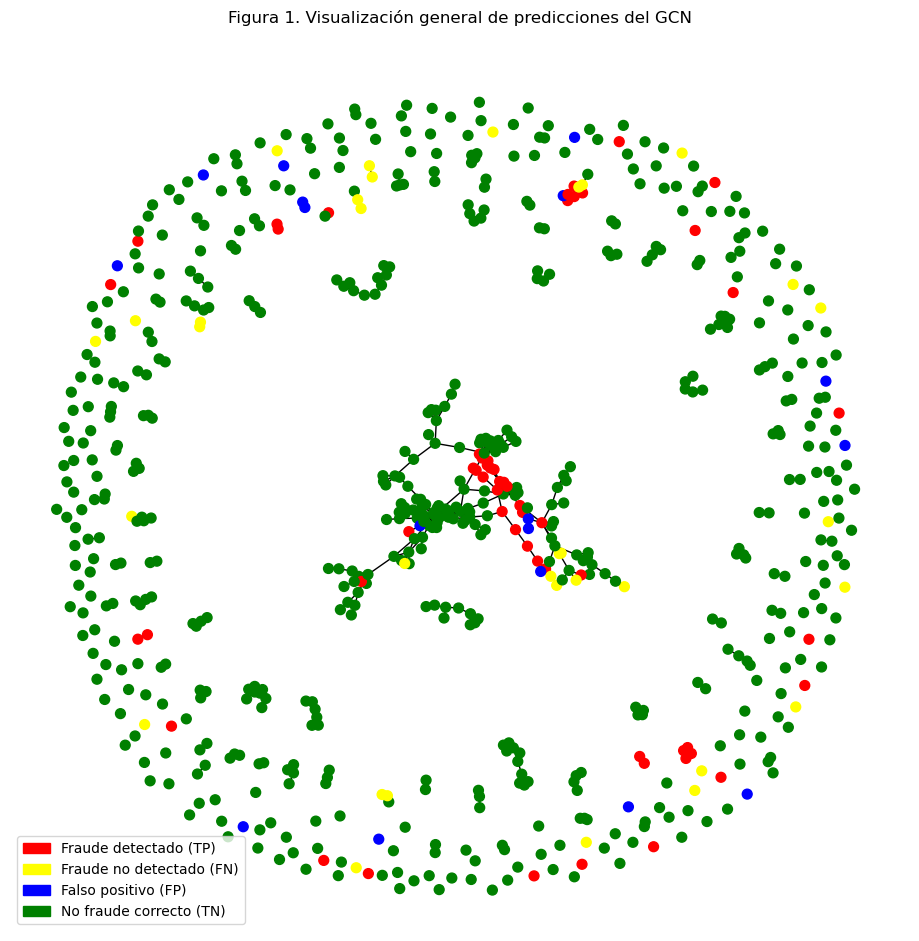

In [13]:
def plot_predictions(data, model, num_nodes_to_plot=700):
    

    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    G = to_networkx(data, to_undirected=True)

    # Limitar a subgrafo si es muy grande 
    if G.number_of_nodes() > num_nodes_to_plot:
        nodes = list(G.nodes())[:num_nodes_to_plot]
        G = G.subgraph(nodes)

    color_map = []
    for node in G.nodes():
        true_label = int(data.y[node])
        predicted_label = int(pred[node])

        if true_label == 1 and predicted_label == 1:
            color_map.append('red')       # Verdadero positivo (fraude detectado)
        elif true_label == 1 and predicted_label == 0:
            color_map.append('yellow')    # Falso negativo (fraude no detectado)
        elif true_label == 0 and predicted_label == 1:
            color_map.append('blue')      # Falso positivo (no fraude detectado como fraude)
        else:
            color_map.append('green')     # Verdadero negativo

    # Dibujar
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(9, 9))
    nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=50)

    plt.title("Figura 1. Visualizacion general de predicciones del GCN")

    legend_elements = [
        Patch(color='red', label='Fraude detectado (TP)'),
        Patch(color='yellow', label='Fraude no detectado (FN)'),
        Patch(color='blue', label='Falso positivo (FP)'),
        Patch(color='green', label='No fraude correcto (TN)')
    ]
    plt.legend(handles=legend_elements, loc='lower left')

    plt.show()

plot_predictions(data, model)

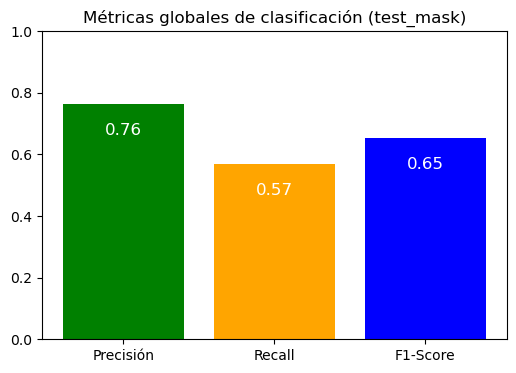

In [14]:
def evaluate_and_plot_metrics(data, pred, mask_name='test_mask'):
    # Se extraen etiquetas verdaderas y predicciones para el subconjunto (test_mask)
    mask = getattr(data, mask_name)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()

    # Se calculan metricas
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    names = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(6,4))
    bars = plt.bar(names, values, color=['green', 'orange', 'blue'])
    plt.ylim(0, 1)
    plt.title(f'Metricas globales de clasificacion ({mask_name})')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.1, f'{height:.2f}', ha='center', color='white', fontsize=12)

    plt.show()

# Se usa la funcion con las predicciones del modelo
model.eval()
out = model(data)
pred = out.argmax(dim=1)

evaluate_and_plot_metrics(data, pred, 'test_mask')